In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm, pipeline
from sklearn.preprocessing import PolynomialFeatures

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

kn = tmh.KNN_Helper()

import transform_helper
%aimport transform_helper

th = transform_helper.Transformation_Helper()

iph = transform_helper.InfluentialPoints_Helper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

import class_helper
%aimport class_helper


# Scaling

Sometimes it is necessary to restrict the *scale* of our data
- Features and targets

There are several reasons
- Some models are sensitive to scale
    - Features with large differences in scale may affect the model
- Some Loss  functions are sensitive to scale

## Some scalers

Scaling transformations are relatively simple mathematically.

Let's discuss the *how* of scaling before delving into the *why*.

**Note**
Scaling may be applied to a variable regardless of whether it is a feature of target.



### MinMax

Convert to $[0,1]$ range.

$$
\tilde{\x}^\ip_j = \frac{ \x^\ip_j -  \min{1 \le i \le m}(\x^\ip_j) }{ \min{1 \le i \le m}(\x^\ip_j) - \min{1 \le i \le m}(\x^\ip_j }
$$

New feature is measured in units of "fraction of range".

### Standardize

$$
\tilde{\x}^\ip_j = { { \x^\ip_j - \bar{\x_j} } \over { \sigma_{\x_j}} }
$$

The new feature has a mean of $0$, i.e., is *zero centered*.

New feature is measured in units of "number of standard deviations".


## Loss functions sensitive to scale

One reason for scaling features is the mathematics of the model.

Consider the behavior of the KNN Classification model
on a set of examples in which the two features $\x_1, \x_2$ are roughly the same scale.




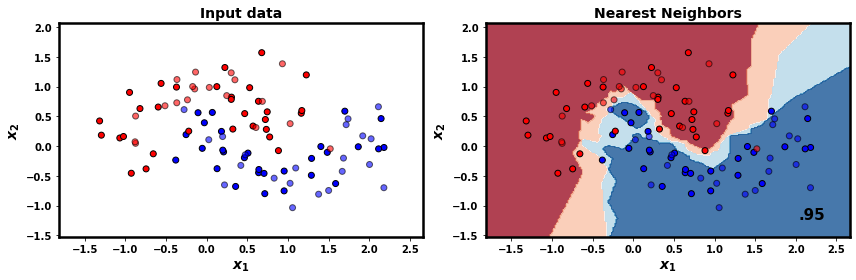

In [4]:
_=  kn.plot_classifiers(scale=False)

What would happen if the scales were very different for the two features ?

Let's "stretch" the first feature by multiplying it by a factor of 10, leaving the second feature unchanged.

(n.b., accuracy is the number in the lower right of the prediction plot)


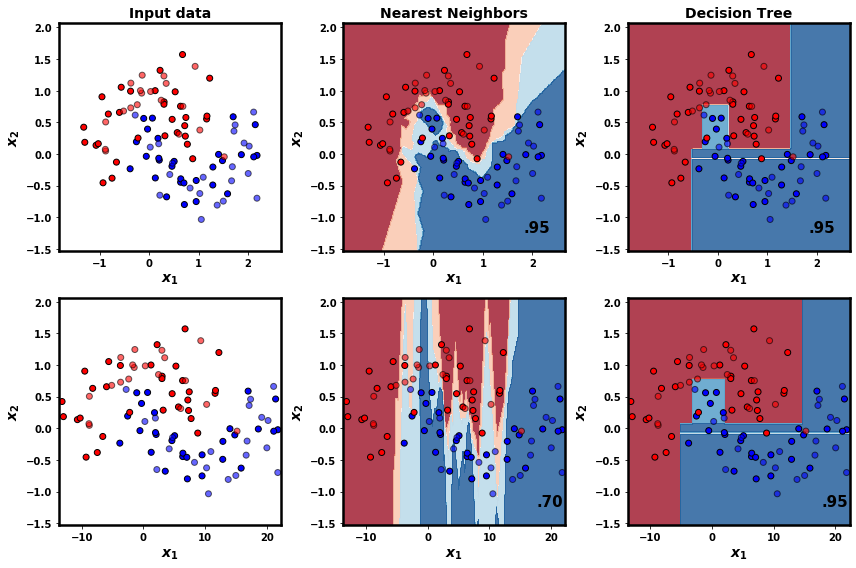

In [5]:
kn = tmh.KNN_Helper()

_ = kn.plot_classifiers(scale=False, num_ds=2)

The first row shows the original dataset; the second the "stretched" data set (i.e., scale of $\x_1$)

**Note** the horizontal scale of the lower plot is 10 times the upper.
- The plots look the same because the plotting routine keeps the plot sizes the same.

As you can see, the KNN classifier produces drastically different results on the two datasets.

Arguably KNN's predictions on the stretched dataset feel overfit.
- Even with overfitting: accuracy drops from 95% to 70%

What is the reason for this ?

If you recall our brief introduction to KNN: 
- The classifier measures the distance between features in a test example and feature in (each) training example
- The distance measure (L2, sum of squared feature-wise differences) is sensitive to scale

$$
\begin{array}[lll]\\
(\x^\ip_1, \x^\ip_2) & \text{training example } i \\
(10 * \x^\ip_1, \x^\ip_2) & \text{stretched training example } i \\
\\
(\x^{(test)}_1, \x^{(test)}_2) & \text{test example} \\
\end{array}
$$

$$
\begin{array}[lll]\\
(\x^{(test)}_1 - \x^\ip_1)^2 & + (\x^{(test)}_2 - \x^\ip_2)^2  & \text{distance from test}\\
(\x^{(test)}_1 -  10 *\x^\ip_1)^2 & + (\x^{(test)}_2 - \x^\ip_2)^2 &\text{stretched distance from test}
\end{array}
$$

Differences in $\x_1$ are much more important than differences in $\x_2$ in the stretched data.


The issue is that the distance metric used by KNN is *sensitive to feature scale*.

By rescaling both features to be on a similar scale (as in the raw input)
- We balance the contribution to distance from each feature
- Removing the sensitivity

Let's see how the KNN Classifier and
the Decision Tree classifier (topic of a subsequent lecture)
behave if we re-scale by Standardization

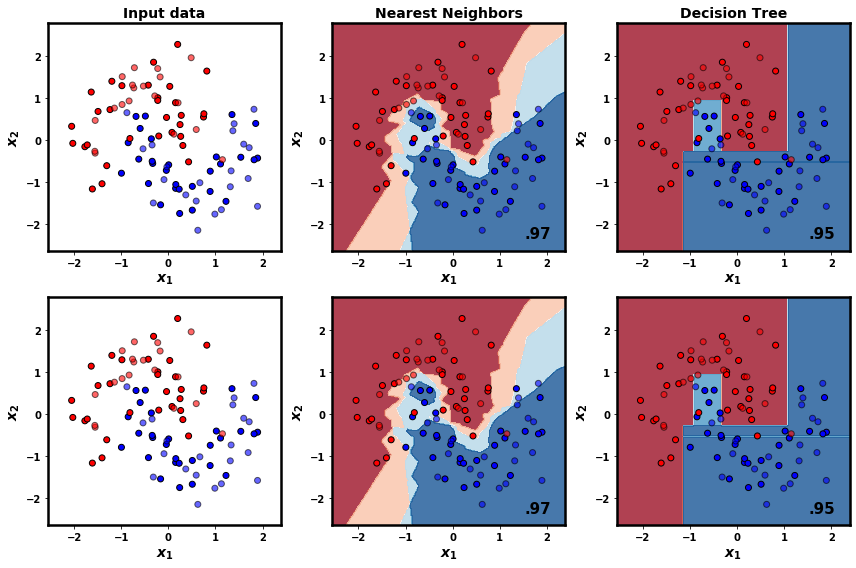

In [6]:
kn = tmh.KNN_Helper()

_ = kn.plot_classifiers(scale=True, num_ds=2)

- Both features now on *identical* scale (Input plot is now of Standardized features)
- The fit of the KNN Classifier is more sensible
    - And Accuracy improves relative to the raw, unscaled input
- The fit and Accuracy of the Decision Tree Classifier is unaffected

So
- The KNN model **is** sensitive to scale
- The Decision Tree model **is not** sensitive to scale.
In contrast, the Decision Tree classifier (which will be the topic of a subsequent lecture)


Differences in scale might inadvertently creep into the data.

- Millimeters rather than meters
- Whole dollars rather than cents (hundredths of a dollar)


**Bottom line**
- Know the math behind your model ! Don't blindly "use an API".

We will encounter scale sensitivity once more
- Upcoming lecture on Principal Components
- Results change when we use
    - The Correlation matrix (i.e., scaled data)
    - The Covariance matrix (i.e., unscaled data)


## Parameters sensitive to scale 



Consider the linear model
$$
\y = \Theta_1 * \x_1
$$

If we inflate $\x_1$ by a factor of 10
then $\Theta_1$ will mathematically need to decrease by the same factor
$$
\begin{array}[ll]\\
\y  & = & \frac{\Theta_1}{10} * ( 10 * \x_1) \\
    & = & \Theta'_1 * \x'_1
\end{array}
$$

Changing the scale of the feature *also* changes the scale of the corresponding parameter.

Why might this matter ?

Again: there are Loss functions where the scale of **parameters** (rather than features) matter.

## Loss functions sensitive to scale: regularization penalty

When a model has too many parameters (always count them!)
- Many elements of the $\Theta$ vector may be near 0

Recall too the symptom of the Dummy Variable trap
- Pairs of parameters with similar absolute magnitude but opposite sign


*Regularization* is a technique
- That modifies the Loss function
- By adding a *penalty*
- With the effect of encouraging small, near zero parameter values

That is, the Loss function becomes a *Regularized Loss*
$$\loss + (\alpha * Q)$$
where 
- $Q$ is a penalty that is a function of $\Theta$
- $\alpha$ is the *strength* of the penalty
- $\loss$ is the unregularized Loss function

(See our Deep Dive notebook section [Regularization](Bias_and_Variance.ipynb#Regularization:-reducing-overfitting) for more detail.

Because scaling a feature may rescale the *corresponding parameter*
- The penalty $Q$ will be affected
- And so too the regularized Loss

[Ridge Regression](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Ridge-regression-%28$L_2$-Regularization%29)
is basically Linear Regression with a penalty that is the sum of squared parameters values

​
$$
Q = \sum_{n=1}^N \Theta_n^2
$$

In our example
- Inflating the sole parameter $\x_1$ by a factor of 10
- Decreases the corresponding parameter $\Theta_1$ by a factor of 10
- Decreases the corresponding penalty by a factor of 100

Note that even something as "benign" as changing units from meters to millimeters has a big effect.


[Lasso Regression](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Lasso-regression-%28$L_1$-regularization%29)
is Linear Regression with a penalty that is the sum of the absolute value of parameters

$$
Q = \alpha\sum_{n=1}^N |\Theta_n|
$$

In our example
- Inflating the sole $\x_1$ parameter by a factor of 10
- Decreases the corresponding parameter $\Theta_1$ by a factor of 10
- Decreases the corresponding penalty by a factor of 10


It is easy to forget (and get burned !) by the Scaling transformation
when you innocently add a Regularization penalty to the loss.

## Feature scaling: summary

- A very simple operation
- With subtle but significant impact

Preview:
- In the Deep Learning part of the course
- We will see the need to scale features
    - Small magnitude


In [12]:
print("Done")

Done
